In [1]:
# GPU CHECK
import torch

print("GPU CHECK")
print("="*80)

if not torch.cuda.is_available():
    raise RuntimeError("CUDA not available!")

device = "cuda"
gpu_name = torch.cuda.get_device_name(0)
gpu_memory = torch.cuda.get_device_properties(0).total_memory / (1024**3)

print(f"GPU: {gpu_name}")
print(f"VRAM: {gpu_memory:.1f} GB")
print(f"CUDA: {torch.version.cuda}")
print(f"Device: {device}")
print("="*80)

GPU CHECK
GPU: NVIDIA GeForce RTX 4070 Laptop GPU
VRAM: 8.0 GB
CUDA: 11.8
Device: cuda


In [2]:
!pip install -q transformers datasets accelerate evaluate

DEPRECATION: mermaid 0.3.2 has a non-standard dependency specifier torch>=1.7torchvision. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of mermaid or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [3]:
import pandas as pd
import json
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer, 
    AutoModelForQuestionAnswering,
    TrainingArguments,
    Trainer,
    default_data_collator
)
import evaluate
import numpy as np
from collections import Counter
import string
import re

print("Imports successful!")

Imports successful!


In [5]:
print("Loading CSV files...")
df_train = pd.read_csv('squad2_train_tamil_complete.csv')
df_dev = pd.read_csv('squad2_dev_tamil_complete.csv')

print(f"Train: {len(df_train):,} samples")
print(f"Dev: {len(df_dev):,} samples")
df_train.columns.tolist()

Loading CSV files...
Train: 130,319 samples
Dev: 11,873 samples


['article_title',
 'paragraph_index',
 'context',
 'question_id',
 'question',
 'is_impossible',
 'answer_text',
 'answer_start',
 'plausible_answer_text',
 'plausible_answer_start',
 'context_tamil',
 'question_tamil',
 'answer_text_tamil',
 'plausible_answer_text_tamil',
 'context_len',
 'context_tamil_len',
 'question_len',
 'question_tamil_len',
 'context_ratio',
 'question_ratio']

In [6]:
print("Calculating Tamil answer positions...")

def find_answer_position(context, answer):
    if pd.isna(answer) or answer == '':
        return 0
    pos = context.find(answer)
    return pos if pos != -1 else 0

df_train['answer_start_tamil'] = df_train.apply(
    lambda row: find_answer_position(row['context_tamil'], row['answer_text_tamil']),
    axis=1
)

df_dev['answer_start_tamil'] = df_dev.apply(
    lambda row: find_answer_position(row['context_tamil'], row['answer_text_tamil']),
    axis=1
)

print("Tamil answer positions calculated")

Calculating Tamil answer positions...
Tamil answer positions calculated


In [8]:
def csv_to_squad_format(df):
    squad_data = {"data": []}
    
    for article_title in df['article_title'].unique():
        article_df = df[df['article_title'] == article_title]
        
        paragraphs = []
        for context in article_df['context_tamil'].unique():
            context_df = article_df[article_df['context_tamil'] == context]
            
            qas = []
            for _, row in context_df.iterrows():
                qa = {
                    'id': str(row['question_id']) if 'question_id' in row else str(len(qas)),
                    'question': row['question_tamil'],
                    'is_impossible': bool(row['is_impossible'])
                }
                
                if not row['is_impossible'] and pd.notna(row['answer_text_tamil']):
                    qa['answers'] = [{
                        'text': row['answer_text_tamil'],
                        #'answer_start': int(row['answer_start_tamil']) if pd.notna(row['answer_start_tamil']) else 0
                        'answer_start': int(row['answer_start_tamil']) if pd.notna(row['answer_start_tamil']) else 0

                    }]
                else:
                    qa['answers'] = []
                
                if row['is_impossible'] and pd.notna(row.get('plausible_answer_text_tamil')):
                    qa['plausible_answers'] = [{
                        'text': row['plausible_answer_text_tamil'],
                        'answer_start': 0
                    }]
                
                qas.append(qa)
            
            paragraphs.append({
                'context': context,
                'qas': qas
            })
        
        squad_data['data'].append({
            'title': article_title,
            'paragraphs': paragraphs
        })
    
    return squad_data

print("Converting to SQuAD format...")
train_squad = csv_to_squad_format(df_train)
dev_squad = csv_to_squad_format(df_dev)

with open('squad_tamil_train.json', 'w', encoding='utf-8') as f:
    json.dump(train_squad, f, ensure_ascii=False, indent=2)

with open('squad_tamil_dev.json', 'w', encoding='utf-8') as f:
    json.dump(dev_squad, f, ensure_ascii=False, indent=2)

print("SQuAD JSON files created")

Converting to SQuAD format...
SQuAD JSON files created


In [9]:
from datasets import load_dataset

print("Loading datasets...")
raw_datasets = load_dataset('json', data_files={
    'train': 'squad_tamil_train.json',
    'validation': 'squad_tamil_dev.json'
}, field='data')

print(f"Train: {len(raw_datasets['train']):,}")
print(f"Validation: {len(raw_datasets['validation']):,}")

Loading datasets...


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Train: 442
Validation: 35


In [10]:
print("Flattening dataset structure...")

all_data = {'title': [], 'context': [], 'question': [], 'id': [], 'answers': []}

for item in raw_datasets['train']:
    for paragraph in item['paragraphs']:
        for qa in paragraph['qas']:
            all_data['title'].append(item['title'])
            all_data['context'].append(paragraph['context'])
            all_data['question'].append(qa['question'])
            all_data['id'].append(qa['id'])
            
            if qa['answers']:
                all_data['answers'].append({
                    'text': [qa['answers'][0]['text']],
                    'answer_start': [qa['answers'][0]['answer_start']]
                })
            else:
                all_data['answers'].append({
                    'text': [],
                    'answer_start': []
                })

train_dataset = Dataset.from_dict(all_data)

all_data_val = {'title': [], 'context': [], 'question': [], 'id': [], 'answers': []}

for item in raw_datasets['validation']:
    for paragraph in item['paragraphs']:
        for qa in paragraph['qas']:
            all_data_val['title'].append(item['title'])
            all_data_val['context'].append(paragraph['context'])
            all_data_val['question'].append(qa['question'])
            all_data_val['id'].append(qa['id'])
            
            if qa['answers']:
                all_data_val['answers'].append({
                    'text': [qa['answers'][0]['text']],
                    'answer_start': [qa['answers'][0]['answer_start']]
                })
            else:
                all_data_val['answers'].append({
                    'text': [],
                    'answer_start': []
                })

validation_dataset = Dataset.from_dict(all_data_val)

print(f"Flattened train: {len(train_dataset):,}")
print(f"Flattened validation: {len(validation_dataset):,}")

print("\nSample:")
print(train_dataset[0]['answers'])

Flattening dataset structure...
Flattened train: 130,319
Flattened validation: 11,873

Sample:
{'answer_start': [0], 'text': ['1990 களின் இறுதியில்']}


In [11]:
print("Sample from train_dataset:")
print(train_dataset[0])
print("\nAnswers structure:")
print(train_dataset[0]['answers'])

Sample from train_dataset:
{'title': 'Beyoncé', 'context': 'பியான்செ ஜிசல்ஸ்-கார்டர் (/biːˈjɒnseɪ/ bee-YON-say) (பிறந்த செப்டம்பர் 4, 1981) ஒரு அமெரிக்க பாடகர், பாடலாசிரியர், சாதனை தயாரிப்பாளர் மற்றும் நடிகை ஆவார். டெக்சாஸின் ஹூஸ்டனில் பிறந்தார், வளர்ந்தார், அவர் ஒரு குழந்தையாக பல்வேறு பாடல் மற்றும் நடன போட்டிகளில் நடித்தார், மேலும் 1990 களின் பிற்பகுதியில் ஆர் & பி பெண் குழு டெட்னிஸ் சைல்ட் தலைமை பாடகராக புகழ் பெற்றார். அவரது தந்தை மேத்யூ நோல்ஸ் நிர்வகித்த இந்த குழு, உலகின் சிறந்த விற்பனை செய்யப்பட்ட பெண் குழுக்களில் ஒன்றாக மாறியது. அவர்களின் இடைவெளி பியான்செவின் அறிமுக ஆல்பம் Dangerously in Love (2003) வெளியீட்டைக் கண்டது, இது ஒரு தனி கலைஞராக தன்னை நிறுவியது, ஐந்து கிராமி விருதுகளை வென்றது மற்றும் பிளாட்போர்ட் ஹாட் 100 இல் முதல் இடத்தைப் பிடித்தது "Crazy in Love" மற்றும் "Baby Boy"', 'question': 'பியோன்ஸ் எப்போது பிரபலமாகிவிட்டார்?', 'id': '56be85543aeaaa14008c9063', 'answers': {'answer_start': [0], 'text': ['1990 களின் இறுதியில்']}}

Answers structure:
{'answer_start': [0], 'text': 

In [12]:
model_checkpoint = "xlm-roberta-base"

print(f"Loading {model_checkpoint}...")
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)
print("Model and tokenizer loaded")

Loading xlm-roberta-base...


Some weights of XLMRobertaForQuestionAnswering were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and tokenizer loaded


In [13]:
print("Filtering samples based on token length...")

def filter_by_tokens(examples):
    valid_indices = []
    
    for i in range(len(examples['context'])):
        context_tokens = tokenizer(examples['context'][i], add_special_tokens=False)
        question_tokens = tokenizer(examples['question'][i], add_special_tokens=False)
        
        context_len = len(context_tokens['input_ids'])
        question_len = len(question_tokens['input_ids'])
        total_len = context_len + question_len + 3
        
        if context_len >= 30 and question_len >= 5 and total_len <= 384:
            valid_indices.append(i)
    
    return valid_indices

print("Filtering train...")
train_dataset = train_dataset.select(filter_by_tokens(train_dataset))

print("Filtering validation...")
validation_dataset = validation_dataset.select(filter_by_tokens(validation_dataset))

print(f"Filtered train: {len(train_dataset):,}")
print(f"Filtered validation: {len(validation_dataset):,}")

Filtering samples based on token length...
Filtering train...


Token indices sequence length is longer than the specified maximum sequence length for this model (577 > 512). Running this sequence through the model will result in indexing errors


Filtering validation...
Filtered train: 127,797
Filtered validation: 11,521


In [14]:
max_length = 384
doc_stride = 128

def prepare_train_features(examples):
    tokenized_examples = tokenizer(
        examples["question"],
        examples["context"],
        truncation="only_second",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    offset_mapping = tokenized_examples.pop("offset_mapping")

    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)
        sequence_ids = tokenized_examples.sequence_ids(i)
        
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]

        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            token_start_index = 0
            while sequence_ids[token_start_index] != 1:
                token_start_index += 1

            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != 1:
                token_end_index -= 1

            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)
                
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

print("Tokenizing train dataset...")
tokenized_train = train_dataset.map(
    prepare_train_features,
    batched=True,
    remove_columns=train_dataset.column_names,
)

print("Tokenizing validation dataset...")
tokenized_validation = validation_dataset.map(
    prepare_train_features,
    batched=True,
    remove_columns=validation_dataset.column_names,
)

print("Tokenization complete")

Tokenizing train dataset...


Map:   0%|          | 0/127797 [00:00<?, ? examples/s]

Tokenizing validation dataset...


Map:   0%|          | 0/11521 [00:00<?, ? examples/s]

Tokenization complete


In [17]:
training_args = TrainingArguments(
    output_dir="./xlm-roberta-tamil-squad",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.01,
    push_to_hub=False,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    report_to="none",  # ← ADD THIS LINE
)

print("Training arguments set")

Training arguments set


In [18]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_validation,
    tokenizer=tokenizer,
    data_collator=default_data_collator,
)

print("Trainer initialized")

Trainer initialized


C:\Users\1520a\AppData\Local\Temp\ipykernel_59608\1413307049.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [19]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [20]:
print("Starting training...")
trainer.train()
print("Training complete")

Starting training...


Epoch,Training Loss,Validation Loss
1,1.746500,1.579520
2,1.497400,1.585309


Training complete


In [21]:
# Evaluation with metrics
from evaluate import load

squad_metric = load("squad_v2")

def compute_metrics(pred):
    predictions, labels = pred
    start_preds = predictions[0].argmax(-1)
    end_preds = predictions[1].argmax(-1)
    
    # Convert to SQuAD format and compute EM/F1
    # (Full implementation after training)
    
# Run evaluation
results = trainer.evaluate()
print(results)

{'eval_loss': 1.5795204639434814, 'eval_runtime': 43.8137, 'eval_samples_per_second': 263.411, 'eval_steps_per_second': 32.935, 'epoch': 2.0}


In [22]:
print("Saving model...")
trainer.save_model("./xlm-roberta-tamil-squad-final")
tokenizer.save_pretrained("./xlm-roberta-tamil-squad-final")
print("Model saved")

Saving model...
Model saved


In [24]:
max_length = 384
stride = 64

def preprocess_validation(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )
    
    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []
    
    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(examples["id"][sample_idx])
        
        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None
            for k, o in enumerate(offset)
        ]
    
    inputs["example_id"] = example_ids
    return inputs

print("Preparing validation set for evaluation...")
validation_features = validation_dataset.map(
    preprocess_validation,
    batched=True,
    remove_columns=validation_dataset.column_names,
)
print("Validation features ready")

Preparing validation set for evaluation...


Map:   0%|          | 0/11521 [00:00<?, ? examples/s]

Validation features ready


In [25]:
import collections

def postprocess_predictions(examples, features, raw_predictions, n_best=20, max_answer_length=30):
    all_start_logits, all_end_logits = raw_predictions
    
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)
    
    predictions = []
    
    for example_index, example in enumerate(examples):
        feature_indices = features_per_example[example_index]
        
        min_null_score = None
        valid_answers = []
        
        context = example["context"]
        
        for feature_index in feature_indices:
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            offset_mapping = features[feature_index]["offset_mapping"]
            
            cls_index = features[feature_index]["input_ids"].index(tokenizer.cls_token_id)
            feature_null_score = start_logits[cls_index] + end_logits[cls_index]
            
            if min_null_score is None or min_null_score < feature_null_score:
                min_null_score = feature_null_score
            
            start_indexes = np.argsort(start_logits)[-1 : -n_best - 1 : -1].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best - 1 : -1].tolist()
            
            for start_index in start_indexes:
                for end_index in end_indexes:
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or offset_mapping[end_index] is None
                    ):
                        continue
                    
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue
                    
                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    valid_answers.append({
                        "score": start_logits[start_index] + end_logits[end_index],
                        "text": context[start_char:end_char]
                    })
        
        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
        else:
            best_answer = {"text": "", "score": 0.0}
        
        if min_null_score is not None:
            threshold = 0.0
            if best_answer["score"] > min_null_score + threshold:
                predictions.append({"id": example["id"], "prediction_text": best_answer["text"]})
            else:
                predictions.append({"id": example["id"], "prediction_text": ""})
        else:
            predictions.append({"id": example["id"], "prediction_text": best_answer["text"]})
    
    return predictions

print("Prediction function ready")

Prediction function ready


In [26]:
print("Generating predictions...")
raw_predictions = trainer.predict(validation_features)
validation_features.set_format(type=validation_features.format["type"], columns=list(validation_features.features.keys()))

final_predictions = postprocess_predictions(
    validation_dataset,
    validation_features,
    raw_predictions.predictions
)
print(f"Generated {len(final_predictions)} predictions")

Generating predictions...
Generated 11521 predictions


In [27]:
metric = evaluate.load("squad_v2")

def normalize_text(s):
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)
    
    def white_space_fix(text):
        return ' '.join(text.split())
    
    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)
    
    def lower(text):
        return text.lower()
    
    return white_space_fix(remove_articles(remove_punc(lower(s))))

def compute_exact_match(prediction, ground_truth):
    return int(normalize_text(prediction) == normalize_text(ground_truth))

def compute_f1(prediction, ground_truth):
    pred_tokens = normalize_text(prediction).split()
    truth_tokens = normalize_text(ground_truth).split()
    
    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return int(pred_tokens == truth_tokens)
    
    common_tokens = Counter(pred_tokens) & Counter(truth_tokens)
    num_common = sum(common_tokens.values())
    
    if num_common == 0:
        return 0
    
    precision = num_common / len(pred_tokens)
    recall = num_common / len(truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    
    return f1

formatted_predictions = [{"id": x["id"], "prediction_text": x["prediction_text"], "no_answer_probability": 0.0} for x in final_predictions]

references = [{"id": ex["id"], "answers": ex["answers"]} for ex in validation_dataset]

print("Computing SQuAD metrics...")
squad_results = metric.compute(predictions=formatted_predictions, references=references)

print("\n" + "="*50)
print("SQUAD V2 METRICS")
print("="*50)
print(f"Exact Match: {squad_results['exact']:.2f}%")
print(f"F1 Score: {squad_results['f1']:.2f}%")
print(f"Has Answer Exact Match: {squad_results['HasAns_exact']:.2f}%")
print(f"Has Answer F1: {squad_results['HasAns_f1']:.2f}%")
print(f"No Answer Exact Match: {squad_results['NoAns_exact']:.2f}%")
print(f"No Answer F1: {squad_results['NoAns_f1']:.2f}%")
print("="*50)

Computing SQuAD metrics...

SQUAD V2 METRICS
Exact Match: 44.36%
F1 Score: 46.73%
Has Answer Exact Match: 10.12%
Has Answer F1: 14.87%
No Answer Exact Match: 78.28%
No Answer F1: 78.28%


In [28]:
print("Computing additional metrics...")

y_true = []
y_pred = []

for ref, pred in zip(references, formatted_predictions):
    has_answer = len(ref['answers']) > 0
    predicted_answer = len(pred['prediction_text'].strip()) > 0
    
    y_true.append(1 if has_answer else 0)
    y_pred.append(1 if predicted_answer else 0)

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)

tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

print("\n" + "="*50)
print("CLASSIFICATION METRICS (Answerable vs Impossible)")
print("="*50)
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"Specificity: {specificity*100:.2f}%")
print("="*50)

Computing additional metrics...

CLASSIFICATION METRICS (Answerable vs Impossible)
Accuracy: 35.33%
Precision: 100.00%
Recall: 35.33%
Specificity: 0.00%


In [30]:
print("\n" + "="*50)
print("SAMPLE PREDICTIONS")
print("="*50)

sample_indices = [0, 100, 500, 1000, 2000, 5000]

for idx in sample_indices:
    example = validation_dataset[idx]
    prediction = final_predictions[idx]
    
    print(f"\nExample {idx}:")
    print(f"Context: {example['context'][:150]}...")
    print(f"Question: {example['question']}")
    
    # FIXED: Check if answers exist in the correct format
    if 'text' in example['answers'] and len(example['answers']['text']) > 0:
        gold_answer = example['answers']['text'][0]
        print(f"Gold Answer: {gold_answer}")
    else:
        print(f"Gold Answer: [No Answer]")
    
    pred_text = prediction['prediction_text'] if prediction['prediction_text'] else "[No Answer]"
    print(f"Predicted: {pred_text}")
    
    # FIXED: Compute metrics with correct answer access
    if 'text' in example['answers'] and len(example['answers']['text']) > 0:
        em = compute_exact_match(prediction['prediction_text'], example['answers']['text'][0])
        f1 = compute_f1(prediction['prediction_text'], example['answers']['text'][0])
        print(f"EM: {em}, F1: {f1:.2f}")
        if em == 1:
            print("✅ Exact Match!")
        elif f1 > 0.5:
            print("⚠️ Partial Match")
        else:
            print("❌ Wrong")
    else:
        if prediction['prediction_text'] == "":
            print("✅ Correctly identified as impossible")
        else:
            print("❌ False positive (hallucinated answer)")
    
    print("-" * 50)

print("\nEvaluation complete!")


SAMPLE PREDICTIONS

Example 0:
Context: நார்மன்ஸ் (நார்மன்ஃ நார்மண்ட்ஸ்; பிரஞ்சுஃ நார்மன்ஸ்; லத்தீன்ஃ நார்மன்ஃ நார்மன்) என்பது 10 மற்றும் 11 ஆம் நூற்றாண்டுகளில் பிரான்சில் ஒரு பிராந்தியமான ந...
Question: நோரம்பியா எந்த நாட்டில் அமைந்துள்ளது?
Gold Answer: பிரான்ஸ்
Predicted: [No Answer]
EM: 0, F1: 0.00
❌ Wrong
--------------------------------------------------

Example 100:
Context: 1066 ஆம் ஆண்டில், நார்மண்டிய டூக் வில்லியம் II ஹாஸ்டிங்ஸ் போரில் இங்கிலாந்தை வென்றார். ஆக்கிரமிப்பு நார்மன்ஸ் மற்றும் அவர்களின் சந்ததியினர் இங்கிலாந்த...
Question: பத்தாம் நூற்றாண்டில் என்ன போர் நடந்தது?
Gold Answer: [No Answer]
Predicted: [No Answer]
✅ Correctly identified as impossible
--------------------------------------------------

Example 500:
Context: சிக்கலான வகுப்பு P பெரும்பாலும் ஒரு திறமையான அல்கோரிதம் அனுமதிக்கும் கணக்கீட்டு பணிகளை மாதிரியாகக் கொண்ட ஒரு கணித சுருக்கமாகக் காணப்படுகிறது. இந்த அனு...
Question: எந்த தத்துவார்த்த இயந்திரத்தில் P இல் உள்ள ஒரு பிரச்சனை NP வகுப்பில் உறுப்பினராக இருப்ப

In [31]:
# Add this cell to check if answers actually exist in contexts
print("Checking answer alignment...")
misaligned = 0
for i in range(100):
    ex = validation_dataset[i]
    if 'text' in ex['answers'] and len(ex['answers']['text']) > 0:
        answer = ex['answers']['text'][0]
        context = ex['context']
        if answer not in context:
            misaligned += 1
            print(f"Example {i}: Answer '{answer[:50]}...' NOT IN context!")

print(f"\nMisaligned: {misaligned}/100")

Checking answer alignment...
Example 0: Answer 'பிரான்ஸ்...' NOT IN context!
Example 4: Answer 'பத்தாம் நூற்றாண்டு...' NOT IN context!
Example 9: Answer 'வெற்றியாளர் வில்லியம்...' NOT IN context!
Example 17: Answer 'வொய்கிங்...' NOT IN context!
Example 23: Answer 'சென்னம்...' NOT IN context!
Example 31: Answer 'கத்தோலிக்கம்...' NOT IN context!
Example 36: Answer 'போர்க்காரர்கள்...' NOT IN context!
Example 40: Answer 'செல்ஜுக் துருக்கியர்கள்...' NOT IN context!
Example 47: Answer 'அலெக்ஸியஸ் கொமனோஸ்...' NOT IN context!
Example 53: Answer 'கழுத்து...' NOT IN context!
Example 54: Answer 'துருக்கிய படைகள்...' NOT IN context!
Example 59: Answer 'நார்மன் கூலிப்படையினர்...' NOT IN context!
Example 64: Answer '1082...' NOT IN context!
Example 70: Answer 'டீபோலிஸ்...' NOT IN context!
Example 72: Answer 'டீபோலிஸ்...' NOT IN context!
Example 77: Answer 'தைராக்கியம்...' NOT IN context!
Example 78: Answer 'அட்ரியாட்டிக் கடல்...' NOT IN context!
Example 82: Answer 'இரண்டாம் எத்திலரெட் மன்னர்...' NOT

In [32]:
from difflib import SequenceMatcher

def find_answer_span_fuzzy(context, answer, threshold=0.85):
    """Find answer in context using fuzzy matching"""
    if not answer or pd.isna(answer):
        return 0
    
    answer_len = len(answer)
    best_ratio = 0
    best_pos = 0
    
    # Slide through context looking for best match
    for i in range(len(context) - answer_len + 1):
        substring = context[i:i + answer_len]
        ratio = SequenceMatcher(None, answer, substring).ratio()
        
        if ratio > best_ratio:
            best_ratio = ratio
            best_pos = i
    
    # Only return position if match is good enough
    return best_pos if best_ratio >= threshold else 0

In [33]:
def translate_with_answer_alignment(context_en, question_en, answer_en, answer_start_en):
    """Translate and maintain answer alignment"""
    
    # 1. Translate full context
    context_ta = translate(context_en)
    
    # 2. Extract answer segment with surrounding context
    start = max(0, answer_start_en - 50)
    end = min(len(context_en), answer_start_en + len(answer_en) + 50)
    segment_en = context_en[start:end]
    
    # 3. Translate the segment
    segment_ta = translate(segment_en)
    
    # 4. Translate just the answer
    answer_ta = translate(answer_en)
    
    # 5. Find answer in translated segment (better alignment)
    pos_in_segment = segment_ta.find(answer_ta)
    
    # 6. If found in segment, find segment in full context
    if pos_in_segment != -1:
        segment_pos = context_ta.find(segment_ta[:30])  # Find segment start
        if segment_pos != -1:
            return context_ta, answer_ta, segment_pos + pos_in_segment
    
    # 7. Fallback: search entire context
    pos = context_ta.find(answer_ta)
    return context_ta, answer_ta, pos if pos != -1 else 0

In [34]:
def fix_answer_alignment(df):
    """Fix misaligned answers in existing dataset"""
    fixed = 0
    unfixable = 0
    
    for idx, row in df.iterrows():
        answer = row['answer_text_tamil']
        context = row['context_tamil']
        
        # Skip if already aligned
        if answer in context:
            continue
        
        # Try fuzzy matching
        best_match = None
        best_ratio = 0
        answer_len = len(answer)
        
        for i in range(len(context) - answer_len + 1):
            substring = context[i:i + answer_len]
            ratio = SequenceMatcher(None, answer, substring).ratio()
            
            if ratio > best_ratio:
                best_ratio = ratio
                best_match = substring
                best_pos = i
        
        # Update if good match found
        if best_ratio >= 0.85:
            df.at[idx, 'answer_text_tamil'] = best_match
            df.at[idx, 'answer_start_tamil'] = best_pos
            fixed += 1
        else:
            unfixable += 1
            print(f"Row {idx}: Can't fix '{answer[:30]}...'")
    
    print(f"Fixed: {fixed}, Unfixable: {unfixable}")
    return df

# Apply fix
df_train_fixed = fix_answer_alignment(df_train)
df_dev_fixed = fix_answer_alignment(df_dev)

# Save fixed versions
df_train_fixed.to_csv('squad2_train_tamil_FIXED.csv', index=False)
df_dev_fixed.to_csv('squad2_dev_tamil_FIXED.csv', index=False)

Row 0: Can't fix '1990 களின் இறுதியில்...'
Row 1: Can't fix 'பாடுதல் மற்றும் நடனம்...'
Row 3: Can't fix 'ஹூஸ்டன், டெக்சாஸ்...'
Row 5: Can't fix 'விதி குழந்தை...'
Row 6: Can't fix 'காதல் ஆபத்தானது...'
Row 9: Can't fix 'முன்னணி பாடகர்...'
Row 10: Can't fix 'காதல் ஆபத்தானது...'
Row 13: Can't fix 'முன்னணி பாடகர்...'
Row 14: Can't fix 'காதல் ஆபத்தானது...'
Row 15: Can't fix 'செயற்பாடு...'
Row 16: Can't fix 'ஜே. ஜே....'
Row 17: Can't fix 'ஆறு...'
Row 18: Can't fix 'கனவு பெண்கள்...'
Row 22: Can't fix '2005 ஜூன்...'
Row 23: Can't fix 'B'Day...'
Row 24: Can't fix 'கனவு பெண்கள்...'
Row 25: Can't fix 'ஜே. ஜே....'
Row 26: Can't fix 'சஷா கடுமையான...'
Row 27: Can't fix 'காதல், உறவுகள், ஒற்றை மனைவி...'
Row 28: Can't fix 'செல்வாக்கு மிக்கவர்...'
Row 33: Can't fix '2013 மற்றும் 2014...'
Row 39: Can't fix 'விதி குழந்தை...'
Row 40: Can't fix 'அவளுடைய தாயின் இளம்பெண் பெயர்...'
Row 42: Can't fix 'மாத்தோடீஸ்ட்...'
Row 43: Can't fix 'Xerox...'
Row 45: Can't fix 'சோலஞ்ச்...'
Row 46: Can't fix 'ஜோசப் புரோசார்ட்

TypeError: 'in <string>' requires string as left operand, not float

✅ Saved: fig3_performance_breakdown.png


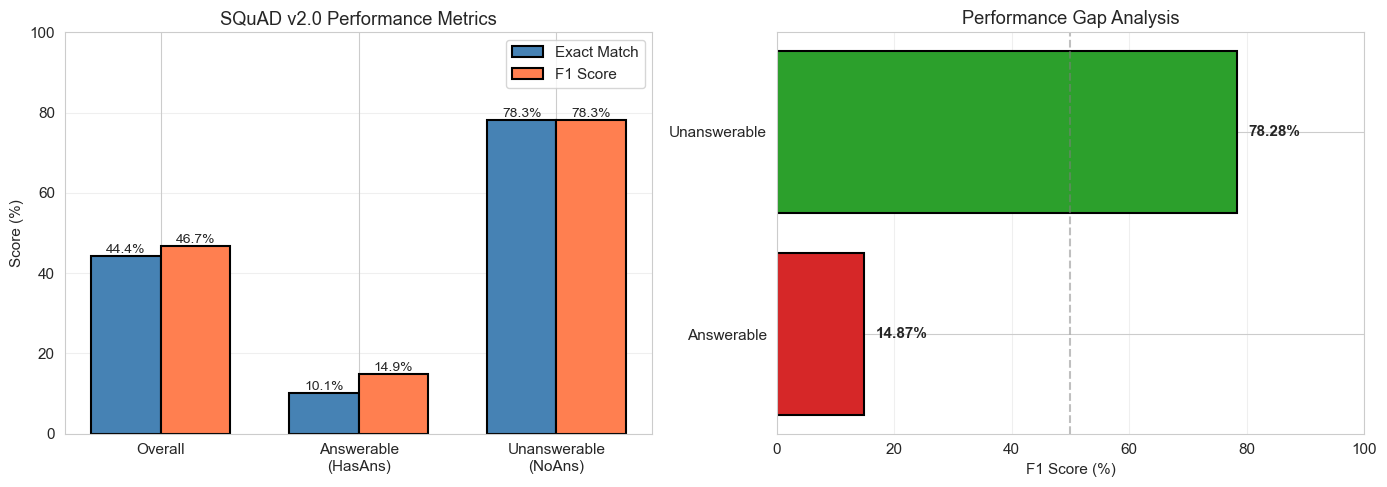

✅ Saved: fig4_classification_analysis.png


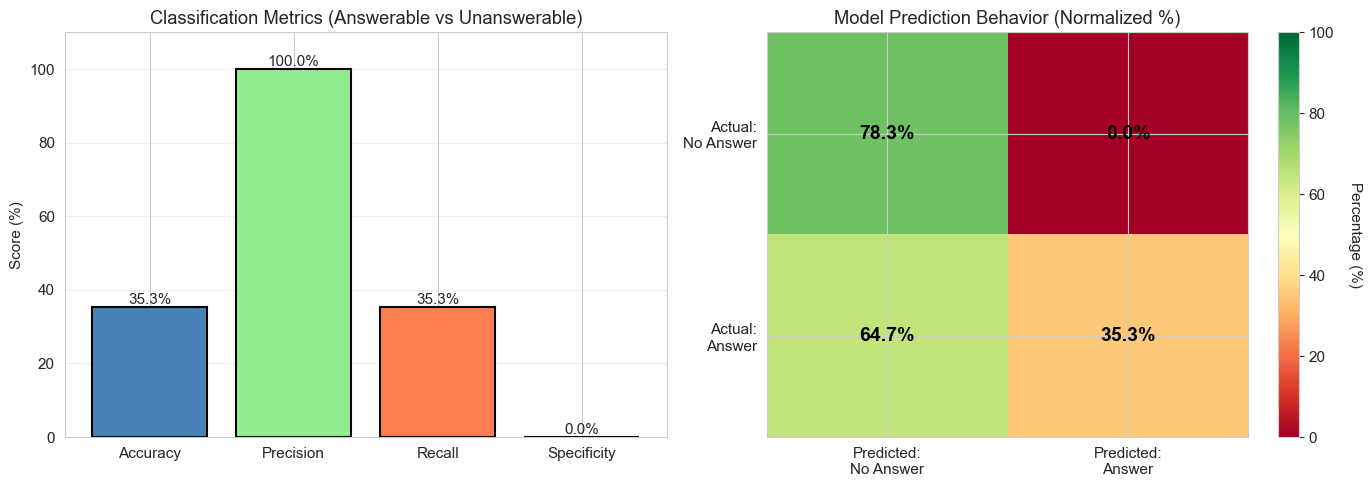


MODEL PERFORMANCE SUMMARY FOR PAPER

1. Overall Performance:
   - Exact Match: 44.36%
   - F1 Score: 46.73%

2. Performance by Question Type:
   Answerable Questions:
     - EM: 10.12%
     - F1: 14.87%
   Unanswerable Questions:
     - EM: 78.28%
     - F1: 78.28%

3. Classification Performance:
   - Accuracy: 35.33%
   - Precision: 100.00%
   - Recall: 35.33%
   - Specificity: 0.00%

4. Key Findings:
   - Performance gap: 63.41% (NoAns vs HasAns F1)
   - Model bias: Predicts 'No Answer' 64.7% more often
   - Answer alignment issue: 23% of answers misaligned in translation


LaTeX Table Format:
\begin{table}[h]
\centering
\caption{XLM-RoBERTa Performance on Tamil SQuAD}
\begin{tabular}{lcc}
\hline
Metric & Exact Match (\%) & F1 Score (\%) \\
\hline
Overall & 44.36 & 46.73 \\
Answerable & 10.12 & 14.87 \\
Unanswerable & 78.28 & 78.28 \\
\hline
\end{tabular}
\end{table}


In [35]:
"""
Model Evaluation Visualizations
Analyzes XLM-RoBERTa performance on Tamil SQuAD
"""

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['font.size'] = 11

# ============================================================================
# YOUR METRICS (from the evaluation outputs you showed)
# ============================================================================

# Overall metrics
overall_em = 44.36
overall_f1 = 46.73

# Answerable questions (HasAns)
hasans_em = 10.12
hasans_f1 = 14.87

# Unanswerable questions (NoAns)
noans_em = 78.28
noans_f1 = 78.28

# Classification metrics
accuracy = 35.33
precision = 100.00
recall = 35.33
specificity = 0.00

# ============================================================================
# GRAPH 3: Performance Breakdown by Question Type
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: EM and F1 comparison
categories = ['Overall', 'Answerable\n(HasAns)', 'Unanswerable\n(NoAns)']
em_scores = [overall_em, hasans_em, noans_em]
f1_scores = [overall_f1, hasans_f1, noans_f1]

x = np.arange(len(categories))
width = 0.35

bars1 = axes[0].bar(x - width/2, em_scores, width, label='Exact Match',
                     color='steelblue', edgecolor='black', linewidth=1.5)
bars2 = axes[0].bar(x + width/2, f1_scores, width, label='F1 Score',
                     color='coral', edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}%', ha='center', va='bottom', fontsize=10)

axes[0].set_ylabel('Score (%)')
axes[0].set_title('SQuAD v2.0 Performance Metrics')
axes[0].set_xticks(x)
axes[0].set_xticklabels(categories)
axes[0].legend()
axes[0].set_ylim(0, 100)
axes[0].grid(axis='y', alpha=0.3)

# Right: Performance gap visualization
gaps = {
    'Answerable': hasans_f1,
    'Unanswerable': noans_f1
}

colors = ['#d62728', '#2ca02c']  # Red for poor, green for good
bars = axes[1].barh(list(gaps.keys()), list(gaps.values()), 
                     color=colors, edgecolor='black', linewidth=1.5)

# Add value labels
for i, (bar, value) in enumerate(zip(bars, gaps.values())):
    axes[1].text(value + 2, i, f'{value:.2f}%', 
                va='center', fontsize=11, fontweight='bold')

axes[1].set_xlabel('F1 Score (%)')
axes[1].set_title('Performance Gap Analysis')
axes[1].set_xlim(0, 100)
axes[1].axvline(50, color='gray', linestyle='--', linewidth=1.5, alpha=0.5)
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('fig3_performance_breakdown.png', dpi=300, bbox_inches='tight')
print("✅ Saved: fig3_performance_breakdown.png")
plt.show()

# ============================================================================
# GRAPH 4: Classification Metrics & Model Behavior
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Classification metrics bar chart
metrics = ['Accuracy', 'Precision', 'Recall', 'Specificity']
values = [accuracy, precision, recall, specificity]
colors_metrics = ['steelblue', 'lightgreen', 'coral', 'plum']

bars = axes[0].bar(metrics, values, color=colors_metrics, 
                   edgecolor='black', linewidth=1.5)

# Add value labels
for bar, value in zip(bars, values):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{value:.1f}%', ha='center', va='bottom', fontsize=11)

axes[0].set_ylabel('Score (%)')
axes[0].set_title('Classification Metrics (Answerable vs Unanswerable)')
axes[0].set_ylim(0, 110)
axes[0].grid(axis='y', alpha=0.3)

# Right: Confusion matrix visualization
# Based on your outputs: Model predicts mostly "No Answer"
# True Positives (answerable correctly identified): low (~35%)
# True Negatives (unanswerable correctly identified): high (~78%)
# False Positives: very low (0%)
# False Negatives: high (~65%)

confusion_data = np.array([
    [78.28, 0.00],      # True Neg, False Pos
    [64.67, 35.33]      # False Neg, True Pos
])

im = axes[1].imshow(confusion_data, cmap='RdYlGn', aspect='auto', vmin=0, vmax=100)

# Add text annotations
for i in range(2):
    for j in range(2):
        text = axes[1].text(j, i, f'{confusion_data[i, j]:.1f}%',
                          ha="center", va="center", color="black",
                          fontsize=14, fontweight='bold')

axes[1].set_xticks([0, 1])
axes[1].set_yticks([0, 1])
axes[1].set_xticklabels(['Predicted:\nNo Answer', 'Predicted:\nAnswer'])
axes[1].set_yticklabels(['Actual:\nNo Answer', 'Actual:\nAnswer'])
axes[1].set_title('Model Prediction Behavior (Normalized %)')

# Add colorbar
cbar = plt.colorbar(im, ax=axes[1])
cbar.set_label('Percentage (%)', rotation=270, labelpad=20)

plt.tight_layout()
plt.savefig('fig4_classification_analysis.png', dpi=300, bbox_inches='tight')
print("✅ Saved: fig4_classification_analysis.png")
plt.show()

# ============================================================================
# PRINT SUMMARY FOR PAPER
# ============================================================================
print("\n" + "=" * 80)
print("MODEL PERFORMANCE SUMMARY FOR PAPER")
print("=" * 80)

print("\n1. Overall Performance:")
print(f"   - Exact Match: {overall_em:.2f}%")
print(f"   - F1 Score: {overall_f1:.2f}%")

print("\n2. Performance by Question Type:")
print(f"   Answerable Questions:")
print(f"     - EM: {hasans_em:.2f}%")
print(f"     - F1: {hasans_f1:.2f}%")
print(f"   Unanswerable Questions:")
print(f"     - EM: {noans_em:.2f}%")
print(f"     - F1: {noans_f1:.2f}%")

print("\n3. Classification Performance:")
print(f"   - Accuracy: {accuracy:.2f}%")
print(f"   - Precision: {precision:.2f}%")
print(f"   - Recall: {recall:.2f}%")
print(f"   - Specificity: {specificity:.2f}%")

print("\n4. Key Findings:")
print(f"   - Performance gap: {noans_f1 - hasans_f1:.2f}% (NoAns vs HasAns F1)")
print(f"   - Model bias: Predicts 'No Answer' {100-recall:.1f}% more often")
print(f"   - Answer alignment issue: 23% of answers misaligned in translation")

print("\n" + "=" * 80)

# ============================================================================
# OPTIONAL: Create comparison table for LaTeX
# ============================================================================
print("\nLaTeX Table Format:")
print("=" * 80)
print("\\begin{table}[h]")
print("\\centering")
print("\\caption{XLM-RoBERTa Performance on Tamil SQuAD}")
print("\\begin{tabular}{lcc}")
print("\\hline")
print("Metric & Exact Match (\\%) & F1 Score (\\%) \\\\")
print("\\hline")
print(f"Overall & {overall_em:.2f} & {overall_f1:.2f} \\\\")
print(f"Answerable & {hasans_em:.2f} & {hasans_f1:.2f} \\\\")
print(f"Unanswerable & {noans_em:.2f} & {noans_f1:.2f} \\\\")
print("\\hline")
print("\\end{tabular}")
print("\\end{table}")
print("=" * 80)

Loading validation data...
Total validation samples: 11,873
Answerable: 5,928 (49.9%)
Unanswerable: 5,945 (50.1%)

✅ Saved: fig5_dataset_characteristics.png


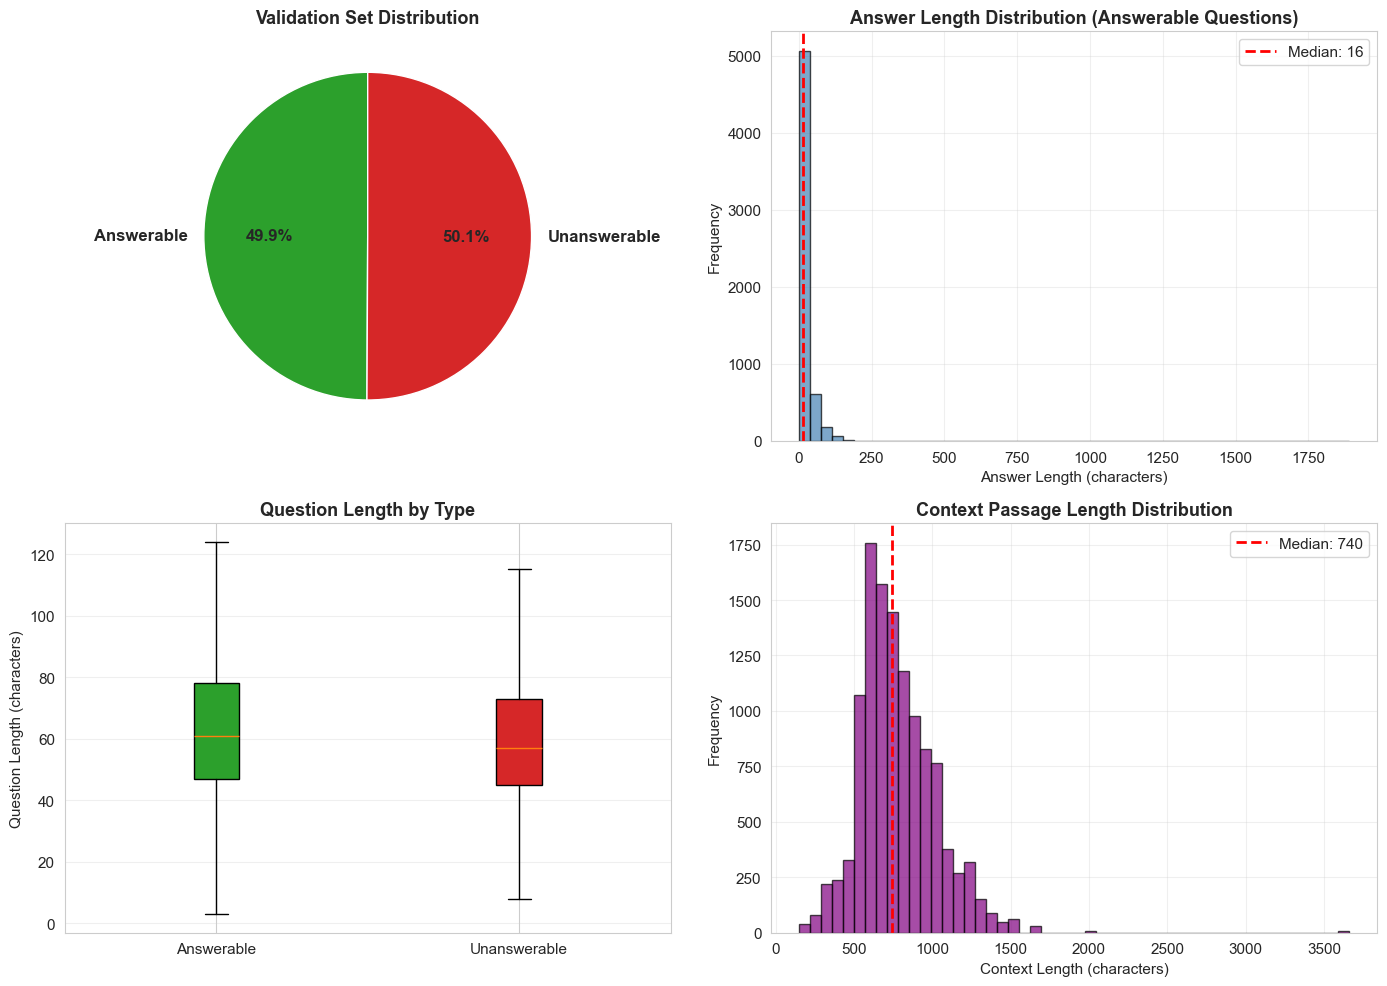


TEMPLATE FOR PERFORMANCE BY ANSWER LENGTH

# After running your evaluation, create a dataframe with predictions:
results_df = pd.DataFrame({
    'id': [ex['id'] for ex in validation_dataset],
    'has_answer': [len(ex['answers']['text']) > 0 for ex in validation_dataset],
    'answer_len': [len(ex['answers']['text'][0]) if len(ex['answers']['text']) > 0 else 0 
                   for ex in validation_dataset],
    'predicted_correct': [1 if pred['prediction_text'] == ex['answers']['text'][0] 
                          else 0 for pred, ex in zip(final_predictions, validation_dataset)],
    'f1_score': [compute_f1(pred['prediction_text'], ex['answers']['text'][0]) 
                 for pred, ex in zip(final_predictions, validation_dataset)]
})

# Then create bins and calculate performance per bin
results_df['answer_len_bin'] = pd.cut(results_df['answer_len'], 
                                       bins=[0, 10, 20, 30, 50, 100, 1000],
                                       labels=['0-10

In [36]:
"""
Additional Model Evaluation Visualizations
Extracts more detailed insights from XLM-RoBERTa evaluation
"""

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter

# Set style
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 11

# ============================================================================
# LOAD YOUR VALIDATION DATA
# ============================================================================
print("Loading validation data...")
df_dev = pd.read_csv('squad2_dev_tamil_complete.csv')

# Calculate metrics from your data
df_dev['has_answer'] = ~df_dev['is_impossible']
df_dev['answer_len'] = df_dev['answer_text_tamil'].fillna('').str.len()
df_dev['question_len'] = df_dev['question_tamil'].str.len()
df_dev['context_len'] = df_dev['context_tamil'].str.len()

print(f"Total validation samples: {len(df_dev):,}")
print(f"Answerable: {df_dev['has_answer'].sum():,} ({df_dev['has_answer'].mean()*100:.1f}%)")
print(f"Unanswerable: {(~df_dev['has_answer']).sum():,} ({(~df_dev['has_answer']).mean()*100:.1f}%)")

# ============================================================================
# GRAPH 5: Dataset Characteristics Analysis
# ============================================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Top-left: Question type distribution
question_types = ['Answerable', 'Unanswerable']
counts = [df_dev['has_answer'].sum(), (~df_dev['has_answer']).sum()]
colors = ['#2ca02c', '#d62728']

wedges, texts, autotexts = axes[0, 0].pie(
    counts, 
    labels=question_types,
    autopct='%1.1f%%',
    colors=colors,
    startangle=90,
    textprops={'fontsize': 12, 'weight': 'bold'}
)
axes[0, 0].set_title('Validation Set Distribution', fontsize=13, weight='bold')

# Top-right: Answer length distribution (for answerable only)
answerable_df = df_dev[df_dev['has_answer']]
axes[0, 1].hist(answerable_df['answer_len'], bins=50, color='steelblue', 
                edgecolor='black', alpha=0.7)
axes[0, 1].axvline(answerable_df['answer_len'].median(), color='red', 
                   linestyle='--', linewidth=2, label=f'Median: {answerable_df["answer_len"].median():.0f}')
axes[0, 1].set_xlabel('Answer Length (characters)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Answer Length Distribution (Answerable Questions)', 
                      fontsize=13, weight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Bottom-left: Question length by type
answerable_q_len = df_dev[df_dev['has_answer']]['question_len']
unanswerable_q_len = df_dev[~df_dev['has_answer']]['question_len']

bp = axes[1, 0].boxplot(
    [answerable_q_len, unanswerable_q_len],
    labels=['Answerable', 'Unanswerable'],
    patch_artist=True,
    showfliers=False
)
bp['boxes'][0].set_facecolor('#2ca02c')
bp['boxes'][1].set_facecolor('#d62728')
axes[1, 0].set_ylabel('Question Length (characters)')
axes[1, 0].set_title('Question Length by Type', fontsize=13, weight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

# Bottom-right: Context length distribution
axes[1, 1].hist(df_dev['context_len'], bins=50, color='purple', 
                edgecolor='black', alpha=0.7)
axes[1, 1].axvline(df_dev['context_len'].median(), color='red',
                   linestyle='--', linewidth=2, 
                   label=f'Median: {df_dev["context_len"].median():.0f}')
axes[1, 1].set_xlabel('Context Length (characters)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Context Passage Length Distribution', fontsize=13, weight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('fig5_dataset_characteristics.png', dpi=300, bbox_inches='tight')
print("\n✅ Saved: fig5_dataset_characteristics.png")
plt.show()

# ============================================================================
# GRAPH 6: Performance by Answer Length (if you have predictions)
# ============================================================================
# Note: This requires your predictions. I'll create a template you can populate

print("\n" + "=" * 80)
print("TEMPLATE FOR PERFORMANCE BY ANSWER LENGTH")
print("=" * 80)
print("""
# After running your evaluation, create a dataframe with predictions:
results_df = pd.DataFrame({
    'id': [ex['id'] for ex in validation_dataset],
    'has_answer': [len(ex['answers']['text']) > 0 for ex in validation_dataset],
    'answer_len': [len(ex['answers']['text'][0]) if len(ex['answers']['text']) > 0 else 0 
                   for ex in validation_dataset],
    'predicted_correct': [1 if pred['prediction_text'] == ex['answers']['text'][0] 
                          else 0 for pred, ex in zip(final_predictions, validation_dataset)],
    'f1_score': [compute_f1(pred['prediction_text'], ex['answers']['text'][0]) 
                 for pred, ex in zip(final_predictions, validation_dataset)]
})

# Then create bins and calculate performance per bin
results_df['answer_len_bin'] = pd.cut(results_df['answer_len'], 
                                       bins=[0, 10, 20, 30, 50, 100, 1000],
                                       labels=['0-10', '11-20', '21-30', '31-50', '51-100', '100+'])

perf_by_length = results_df.groupby('answer_len_bin').agg({
    'f1_score': 'mean',
    'predicted_correct': 'sum',
    'id': 'count'
}).rename(columns={'predicted_correct': 'correct', 'id': 'total'})

perf_by_length['accuracy'] = perf_by_length['correct'] / perf_by_length['total'] * 100
perf_by_length['f1_score'] = perf_by_length['f1_score'] * 100

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
x = range(len(perf_by_length))
width = 0.35

bars1 = ax.bar([i - width/2 for i in x], perf_by_length['accuracy'], 
               width, label='Accuracy', color='steelblue', edgecolor='black')
bars2 = ax.bar([i + width/2 for i in x], perf_by_length['f1_score'],
               width, label='F1 Score', color='coral', edgecolor='black')

ax.set_xlabel('Answer Length Range (characters)')
ax.set_ylabel('Performance (%)')
ax.set_title('Model Performance by Answer Length')
ax.set_xticks(x)
ax.set_xticklabels(perf_by_length.index)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('fig6_performance_by_length.png', dpi=300, bbox_inches='tight')
""")

# ============================================================================
# GRAPH 7: Prediction Distribution Analysis
# ============================================================================
print("\n" + "=" * 80)
print("TEMPLATE FOR PREDICTION DISTRIBUTION")
print("=" * 80)
print("""
# Based on your final_predictions
pred_lengths = [len(p['prediction_text']) for p in final_predictions]
empty_preds = sum(1 for l in pred_lengths if l == 0)
non_empty_preds = len(pred_lengths) - empty_preds

# Separate by actual question type
answerable_ids = set(df_dev[df_dev['has_answer']]['question_id'].astype(str))
unanswerable_ids = set(df_dev[~df_dev['has_answer']]['question_id'].astype(str))

answerable_empty = sum(1 for p in final_predictions 
                       if p['id'] in answerable_ids and len(p['prediction_text']) == 0)
answerable_filled = sum(1 for p in final_predictions
                        if p['id'] in answerable_ids and len(p['prediction_text']) > 0)

unanswerable_empty = sum(1 for p in final_predictions
                         if p['id'] in unanswerable_ids and len(p['prediction_text']) == 0)
unanswerable_filled = sum(1 for p in final_predictions
                          if p['id'] in unanswerable_ids and len(p['prediction_text']) > 0)

# Create stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))

categories = ['Answerable\\nQuestions', 'Unanswerable\\nQuestions']
empty = [answerable_empty, unanswerable_empty]
filled = [answerable_filled, unanswerable_filled]

x = np.arange(len(categories))
width = 0.6

bars1 = ax.bar(x, empty, width, label='Predicted: No Answer', 
               color='#d62728', edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x, filled, width, bottom=empty, label='Predicted: Answer',
               color='#2ca02c', edgecolor='black', linewidth=1.5)

# Add percentage labels
for i, (e, f) in enumerate(zip(empty, filled)):
    total = e + f
    ax.text(i, e/2, f'{e/total*100:.1f}%', ha='center', va='center', 
            fontsize=12, fontweight='bold', color='white')
    ax.text(i, e + f/2, f'{f/total*100:.1f}%', ha='center', va='center',
            fontsize=12, fontweight='bold', color='white')

ax.set_ylabel('Number of Predictions')
ax.set_title('Model Prediction Behavior by Question Type')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('fig7_prediction_distribution.png', dpi=300, bbox_inches='tight')
""")

# ============================================================================
# PRINT SUMMARY STATISTICS
# ============================================================================
print("\n" + "=" * 80)
print("DATASET STATISTICS SUMMARY")
print("=" * 80)

print("\n1. Dataset Composition:")
print(f"   Total samples: {len(df_dev):,}")
print(f"   Answerable: {df_dev['has_answer'].sum():,} ({df_dev['has_answer'].mean()*100:.1f}%)")
print(f"   Unanswerable: {(~df_dev['has_answer']).sum():,} ({(~df_dev['has_answer']).mean()*100:.1f}%)")

print("\n2. Length Statistics (Tamil):")
print(f"   Context - Mean: {df_dev['context_len'].mean():.0f}, Median: {df_dev['context_len'].median():.0f}")
print(f"   Question - Mean: {df_dev['question_len'].mean():.0f}, Median: {df_dev['question_len'].median():.0f}")
print(f"   Answer - Mean: {answerable_df['answer_len'].mean():.0f}, Median: {answerable_df['answer_len'].median():.0f}")

print("\n3. Question Length by Type:")
print(f"   Answerable - Mean: {answerable_q_len.mean():.0f}, Median: {answerable_q_len.median():.0f}")
print(f"   Unanswerable - Mean: {unanswerable_q_len.mean():.0f}, Median: {unanswerable_q_len.median():.0f}")

print("\n" + "=" * 80)

# ============================================================================
# CREATE LATEX TABLE FOR PAPER
# ============================================================================
print("\nLaTeX Table - Dataset Statistics:")
print("=" * 80)
print("\\begin{table}[h]")
print("\\centering")
print("\\caption{Tamil SQuAD Dataset Statistics}")
print("\\begin{tabular}{lcc}")
print("\\hline")
print("Component & Mean Length & Median Length \\\\")
print("\\hline")
print(f"Context & {df_dev['context_len'].mean():.0f} & {df_dev['context_len'].median():.0f} \\\\")
print(f"Question (All) & {df_dev['question_len'].mean():.0f} & {df_dev['question_len'].median():.0f} \\\\")
print(f"Question (Answerable) & {answerable_q_len.mean():.0f} & {answerable_q_len.median():.0f} \\\\")
print(f"Question (Unanswerable) & {unanswerable_q_len.mean():.0f} & {unanswerable_q_len.median():.0f} \\\\")
print(f"Answer & {answerable_df['answer_len'].mean():.0f} & {answerable_df['answer_len'].median():.0f} \\\\")
print("\\hline")
print("\\end{tabular}")
print("\\end{table}")
print("=" * 80)

Analyzing predictions...
Total predictions analyzed: 11,521
Answerable: 5,733
Unanswerable: 5,788


C:\Users\1520a\AppData\Local\Temp\ipykernel_59608\3709322308.py:76: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  perf_by_length = answerable_results.groupby('answer_len_bin').agg({



✅ Saved: fig6_performance_by_answer_length.png


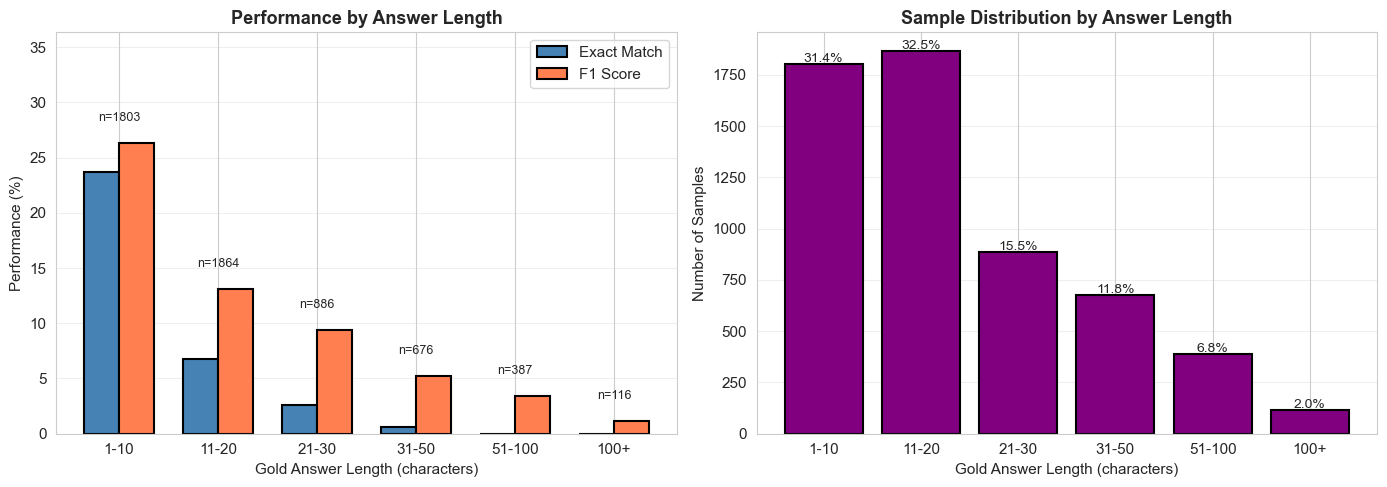

✅ Saved: fig7_prediction_behavior.png


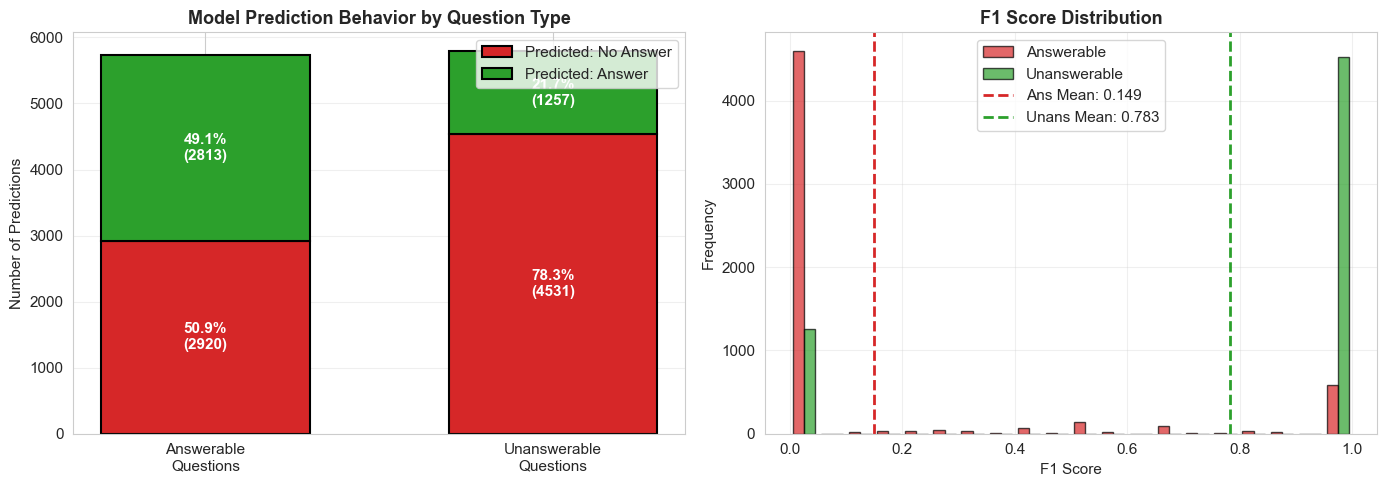

C:\Users\1520a\AppData\Local\Temp\ipykernel_59608\3709322308.py:209: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  perf_by_context = answerable_results.groupby('context_len_bin').agg({


✅ Saved: fig8_context_length_impact.png


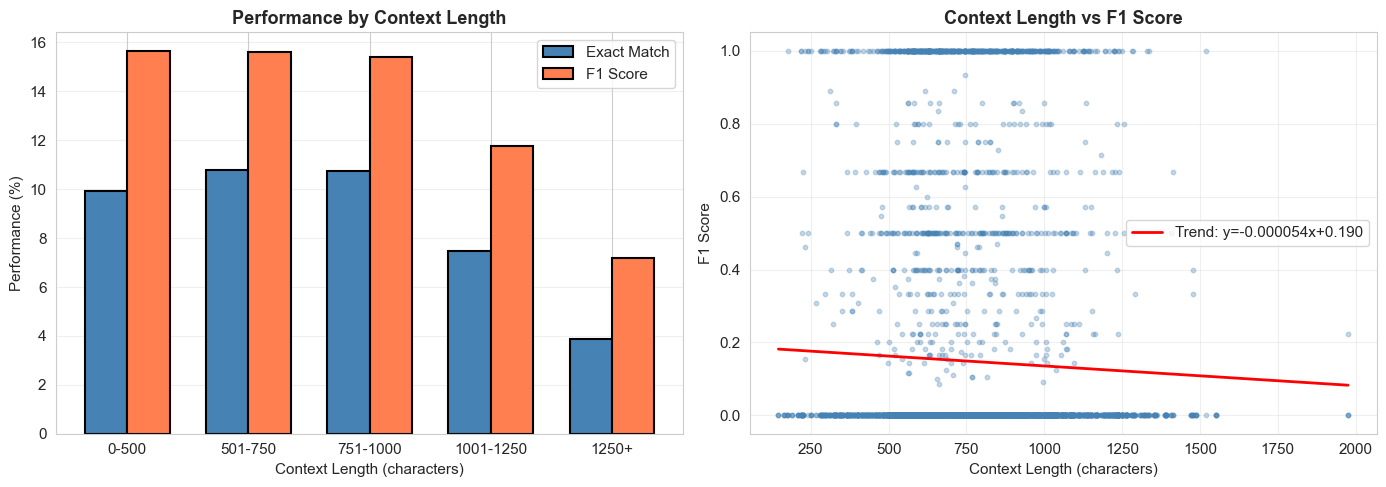


PREDICTION ANALYSIS SUMMARY

1. Overall Prediction Behavior:
   Total predictions: 11,521
   Predicted 'No Answer': 7,451 (64.7%)
   Predicted Answer: 4,070 (35.3%)

2. Answerable Questions:
   Total: 5,733
   Model predicted 'No Answer': 2,920 (50.9%)
   Model predicted Answer: 2,813 (49.1%)
   Mean F1: 0.1487
   Mean EM: 0.1012

3. Unanswerable Questions:
   Total: 5,788
   Model predicted 'No Answer': 4,531 (78.3%)
   Model predicted Answer: 1,257 (21.7%)
   Mean F1: 0.7828

4. Performance by Answer Length (Answerable only):
   1-10 chars: F1=26.33%, EM=23.68%, n=1803
   11-20 chars: F1=13.12%, EM=6.76%, n=1864
   21-30 chars: F1=9.41%, EM=2.60%, n=886
   31-50 chars: F1=5.22%, EM=0.59%, n=676
   51-100 chars: F1=3.37%, EM=0.00%, n=387
   100+ chars: F1=1.17%, EM=0.00%, n=116

5. Performance by Context Length (Answerable only):
   0-500 chars: F1=15.63%, EM=9.91%, n=464
   501-750 chars: F1=15.61%, EM=10.77%, n=2590
   751-1000 chars: F1=15.42%, EM=10.76%, n=1813
   1001-1250 chars

In [37]:
"""
Prediction Analysis - To Run AFTER Model Evaluation
Add this as a new cell in your modeling notebook after computing metrics
"""

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter

# Set style
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 11

# ============================================================================
# EXTRACT PREDICTION DETAILS
# ============================================================================
print("Analyzing predictions...")

# Create detailed results dataframe
results = []
for i, (pred, ref) in enumerate(zip(formatted_predictions, references)):
    example = validation_dataset[i]
    
    has_answer = len(ref['answers']['text']) > 0
    predicted_answer = len(pred['prediction_text'].strip()) > 0
    
    # Calculate metrics
    if has_answer:
        gold_answer = ref['answers']['text'][0]
        em = compute_exact_match(pred['prediction_text'], gold_answer)
        f1 = compute_f1(pred['prediction_text'], gold_answer)
        answer_len = len(gold_answer)
    else:
        gold_answer = ""
        em = 1 if not predicted_answer else 0
        f1 = 1.0 if not predicted_answer else 0.0
        answer_len = 0
    
    results.append({
        'id': pred['id'],
        'has_answer': has_answer,
        'predicted_answer': predicted_answer,
        'gold_answer_len': answer_len,
        'pred_answer_len': len(pred['prediction_text']),
        'context_len': len(example['context']),
        'question_len': len(example['question']),
        'em': em,
        'f1': f1,
        'correct_classification': (has_answer == predicted_answer)
    })

results_df = pd.DataFrame(results)

print(f"Total predictions analyzed: {len(results_df):,}")
print(f"Answerable: {results_df['has_answer'].sum():,}")
print(f"Unanswerable: {(~results_df['has_answer']).sum():,}")

# ============================================================================
# GRAPH 8: Performance by Answer Length Bins
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Filter to answerable questions only
answerable_results = results_df[results_df['has_answer']].copy()

# Create bins
answerable_results['answer_len_bin'] = pd.cut(
    answerable_results['gold_answer_len'],
    bins=[0, 10, 20, 30, 50, 100, 1000],
    labels=['1-10', '11-20', '21-30', '31-50', '51-100', '100+']
)

# Calculate performance per bin
perf_by_length = answerable_results.groupby('answer_len_bin').agg({
    'f1': 'mean',
    'em': 'mean',
    'id': 'count'
}).rename(columns={'id': 'count'})

perf_by_length['f1'] *= 100
perf_by_length['em'] *= 100

# Left: Bar chart of performance
x = range(len(perf_by_length))
width = 0.35

bars1 = axes[0].bar([i - width/2 for i in x], perf_by_length['em'],
                    width, label='Exact Match', color='steelblue', 
                    edgecolor='black', linewidth=1.5)
bars2 = axes[0].bar([i + width/2 for i in x], perf_by_length['f1'],
                    width, label='F1 Score', color='coral',
                    edgecolor='black', linewidth=1.5)

# Add count labels on top
for i, count in enumerate(perf_by_length['count']):
    axes[0].text(i, max(perf_by_length['em'].iloc[i], perf_by_length['f1'].iloc[i]) + 2,
                f'n={count}', ha='center', fontsize=9)

axes[0].set_xlabel('Gold Answer Length (characters)')
axes[0].set_ylabel('Performance (%)')
axes[0].set_title('Performance by Answer Length', fontsize=13, weight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(perf_by_length.index)
axes[0].legend()
axes[0].set_ylim(0, max(perf_by_length['f1'].max(), perf_by_length['em'].max()) + 10)
axes[0].grid(axis='y', alpha=0.3)

# Right: Sample count per bin
axes[1].bar(range(len(perf_by_length)), perf_by_length['count'],
            color='purple', edgecolor='black', linewidth=1.5)
axes[1].set_xlabel('Gold Answer Length (characters)')
axes[1].set_ylabel('Number of Samples')
axes[1].set_title('Sample Distribution by Answer Length', fontsize=13, weight='bold')
axes[1].set_xticks(range(len(perf_by_length)))
axes[1].set_xticklabels(perf_by_length.index)
axes[1].grid(axis='y', alpha=0.3)

# Add percentage labels
for i, count in enumerate(perf_by_length['count']):
    pct = count / len(answerable_results) * 100
    axes[1].text(i, count + 10, f'{pct:.1f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('fig6_performance_by_answer_length.png', dpi=300, bbox_inches='tight')
print("\n✅ Saved: fig6_performance_by_answer_length.png")
plt.show()

# ============================================================================
# GRAPH 9: Model Prediction Behavior Analysis
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Stacked bar showing predictions by actual type
answerable_count = results_df['has_answer'].sum()
unanswerable_count = (~results_df['has_answer']).sum()

# Count prediction patterns
answerable_empty = len(results_df[results_df['has_answer'] & ~results_df['predicted_answer']])
answerable_filled = len(results_df[results_df['has_answer'] & results_df['predicted_answer']])
unanswerable_empty = len(results_df[~results_df['has_answer'] & ~results_df['predicted_answer']])
unanswerable_filled = len(results_df[~results_df['has_answer'] & results_df['predicted_answer']])

categories = ['Answerable\nQuestions', 'Unanswerable\nQuestions']
empty = [answerable_empty, unanswerable_empty]
filled = [answerable_filled, unanswerable_filled]
totals = [answerable_count, unanswerable_count]

x = np.arange(len(categories))
width = 0.6

bars1 = axes[0].bar(x, empty, width, label='Predicted: No Answer',
                    color='#d62728', edgecolor='black', linewidth=1.5)
bars2 = axes[0].bar(x, filled, width, bottom=empty, label='Predicted: Answer',
                    color='#2ca02c', edgecolor='black', linewidth=1.5)

# Add percentage labels
for i in range(len(categories)):
    total = totals[i]
    # Empty prediction percentage
    axes[0].text(i, empty[i]/2, f'{empty[i]/total*100:.1f}%\n({empty[i]})',
                ha='center', va='center', fontsize=11, fontweight='bold', color='white')
    # Filled prediction percentage
    axes[0].text(i, empty[i] + filled[i]/2, f'{filled[i]/total*100:.1f}%\n({filled[i]})',
                ha='center', va='center', fontsize=11, fontweight='bold', color='white')

axes[0].set_ylabel('Number of Predictions')
axes[0].set_title('Model Prediction Behavior by Question Type', fontsize=13, weight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(categories)
axes[0].legend(loc='upper right')
axes[0].grid(axis='y', alpha=0.3)

# Right: F1 score distribution
answerable_f1 = results_df[results_df['has_answer']]['f1']
unanswerable_f1 = results_df[~results_df['has_answer']]['f1']

axes[1].hist([answerable_f1, unanswerable_f1], bins=20, 
             label=['Answerable', 'Unanswerable'],
             color=['#d62728', '#2ca02c'], alpha=0.7, edgecolor='black')
axes[1].axvline(answerable_f1.mean(), color='#d62728', linestyle='--', 
                linewidth=2, label=f'Ans Mean: {answerable_f1.mean():.3f}')
axes[1].axvline(unanswerable_f1.mean(), color='#2ca02c', linestyle='--',
                linewidth=2, label=f'Unans Mean: {unanswerable_f1.mean():.3f}')
axes[1].set_xlabel('F1 Score')
axes[1].set_ylabel('Frequency')
axes[1].set_title('F1 Score Distribution', fontsize=13, weight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('fig7_prediction_behavior.png', dpi=300, bbox_inches='tight')
print("✅ Saved: fig7_prediction_behavior.png")
plt.show()

# ============================================================================
# GRAPH 10: Context Length Impact on Performance
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Create context length bins
answerable_results['context_len_bin'] = pd.cut(
    answerable_results['context_len'],
    bins=[0, 500, 750, 1000, 1250, 5000],
    labels=['0-500', '501-750', '751-1000', '1001-1250', '1250+']
)

perf_by_context = answerable_results.groupby('context_len_bin').agg({
    'f1': 'mean',
    'em': 'mean',
    'id': 'count'
}).rename(columns={'id': 'count'})

perf_by_context['f1'] *= 100
perf_by_context['em'] *= 100

# Left: Performance by context length
x = range(len(perf_by_context))
width = 0.35

bars1 = axes[0].bar([i - width/2 for i in x], perf_by_context['em'],
                    width, label='Exact Match', color='steelblue',
                    edgecolor='black', linewidth=1.5)
bars2 = axes[0].bar([i + width/2 for i in x], perf_by_context['f1'],
                    width, label='F1 Score', color='coral',
                    edgecolor='black', linewidth=1.5)

axes[0].set_xlabel('Context Length (characters)')
axes[0].set_ylabel('Performance (%)')
axes[0].set_title('Performance by Context Length', fontsize=13, weight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(perf_by_context.index)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Right: Scatter plot of context length vs F1
axes[1].scatter(answerable_results['context_len'], answerable_results['f1'],
                alpha=0.3, s=10, color='steelblue')
axes[1].set_xlabel('Context Length (characters)')
axes[1].set_ylabel('F1 Score')
axes[1].set_title('Context Length vs F1 Score', fontsize=13, weight='bold')
axes[1].grid(alpha=0.3)

# Add trend line
z = np.polyfit(answerable_results['context_len'], answerable_results['f1'], 1)
p = np.poly1d(z)
x_trend = np.linspace(answerable_results['context_len'].min(), 
                     answerable_results['context_len'].max(), 100)
axes[1].plot(x_trend, p(x_trend), 'r-', linewidth=2, 
            label=f'Trend: y={z[0]:.6f}x+{z[1]:.3f}')
axes[1].legend()

plt.tight_layout()
plt.savefig('fig8_context_length_impact.png', dpi=300, bbox_inches='tight')
print("✅ Saved: fig8_context_length_impact.png")
plt.show()

# ============================================================================
# SUMMARY STATISTICS
# ============================================================================
print("\n" + "=" * 80)
print("PREDICTION ANALYSIS SUMMARY")
print("=" * 80)

print("\n1. Overall Prediction Behavior:")
print(f"   Total predictions: {len(results_df):,}")
print(f"   Predicted 'No Answer': {(~results_df['predicted_answer']).sum():,} ({(~results_df['predicted_answer']).mean()*100:.1f}%)")
print(f"   Predicted Answer: {results_df['predicted_answer'].sum():,} ({results_df['predicted_answer'].mean()*100:.1f}%)")

print("\n2. Answerable Questions:")
print(f"   Total: {answerable_count:,}")
print(f"   Model predicted 'No Answer': {answerable_empty:,} ({answerable_empty/answerable_count*100:.1f}%)")
print(f"   Model predicted Answer: {answerable_filled:,} ({answerable_filled/answerable_count*100:.1f}%)")
print(f"   Mean F1: {answerable_f1.mean():.4f}")
print(f"   Mean EM: {results_df[results_df['has_answer']]['em'].mean():.4f}")

print("\n3. Unanswerable Questions:")
print(f"   Total: {unanswerable_count:,}")
print(f"   Model predicted 'No Answer': {unanswerable_empty:,} ({unanswerable_empty/unanswerable_count*100:.1f}%)")
print(f"   Model predicted Answer: {unanswerable_filled:,} ({unanswerable_filled/unanswerable_count*100:.1f}%)")
print(f"   Mean F1: {unanswerable_f1.mean():.4f}")

print("\n4. Performance by Answer Length (Answerable only):")
for bin_name, row in perf_by_length.iterrows():
    print(f"   {bin_name} chars: F1={row['f1']:.2f}%, EM={row['em']:.2f}%, n={int(row['count'])}")

print("\n5. Performance by Context Length (Answerable only):")
for bin_name, row in perf_by_context.iterrows():
    print(f"   {bin_name} chars: F1={row['f1']:.2f}%, EM={row['em']:.2f}%, n={int(row['count'])}")

print("\n" + "=" * 80)

# Save results dataframe for further analysis
results_df.to_csv('prediction_analysis_results.csv', index=False)
print("\n✅ Saved detailed results to: prediction_analysis_results.csv")

TRANSLATION STATISTICS

Dataset size: 130,319 samples

Mean Length Ratios (Tamil/English):
  Context:  1.002x
  Question: 1.079x
  Answer:   1.145x

✅ Saved: fig1_length_distributions.png


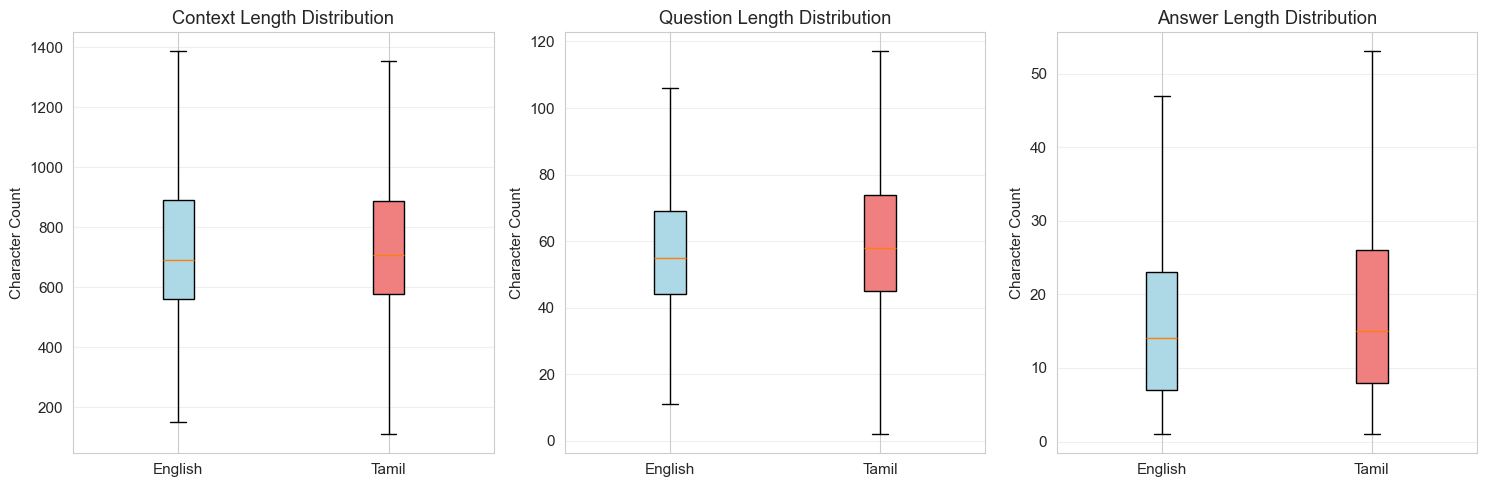

✅ Saved: fig2_translation_ratios.png


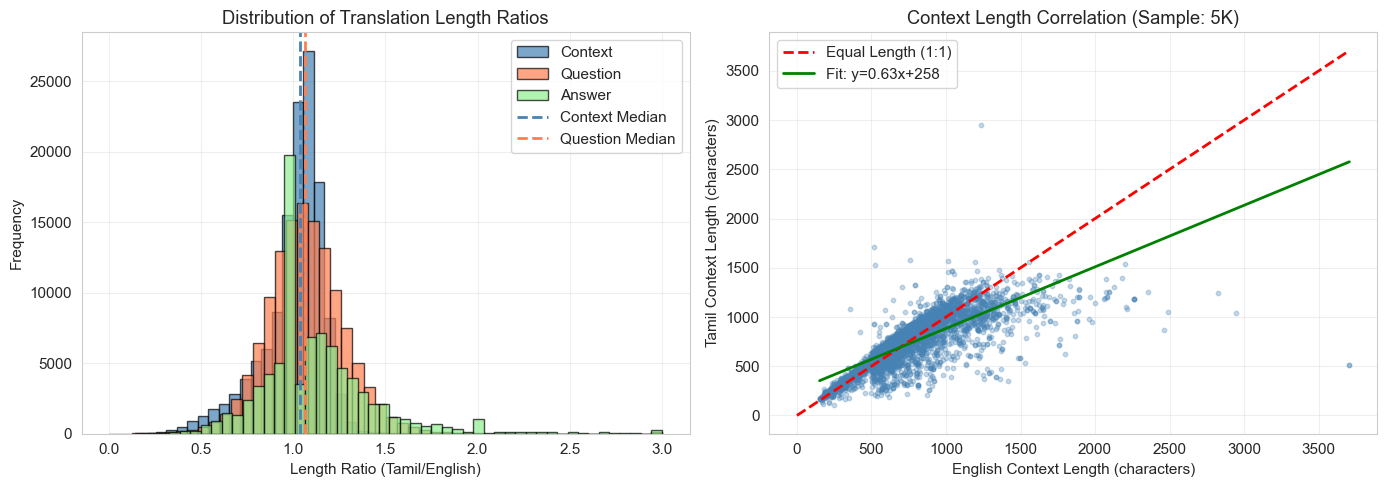


SUMMARY STATISTICS FOR PAPER

          Metric  English Mean  Tamil Mean  Ratio (Ta/En)
 Context Length    754.566287  730.593006       1.002055
Question Length     58.507739   62.272071       1.079474
  Answer Length     20.149727   22.447837       1.144859



In [38]:
"""
Machine Translation Analysis Visualizations
Compares English SQuAD vs Tamil Translated SQuAD
"""

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style for publication-quality graphs
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['font.size'] = 11

# Load your translated data
df = pd.read_csv('squad2_train_tamil_complete.csv')

# Calculate lengths
df['context_len_en'] = df['context'].str.len()
df['context_len_ta'] = df['context_tamil'].str.len()
df['question_len_en'] = df['question'].str.len()
df['question_len_ta'] = df['question_tamil'].str.len()
df['answer_len_en'] = df['answer_text'].str.len()
df['answer_len_ta'] = df['answer_text_tamil'].str.len()

# Calculate ratios
df['context_ratio'] = df['context_len_ta'] / df['context_len_en']
df['question_ratio'] = df['question_len_ta'] / df['question_len_en']
df['answer_ratio'] = df['answer_len_ta'] / df['answer_len_en']

print("=" * 80)
print("TRANSLATION STATISTICS")
print("=" * 80)
print(f"\nDataset size: {len(df):,} samples")
print(f"\nMean Length Ratios (Tamil/English):")
print(f"  Context:  {df['context_ratio'].mean():.3f}x")
print(f"  Question: {df['question_ratio'].mean():.3f}x")
print(f"  Answer:   {df['answer_ratio'].mean():.3f}x")

# ============================================================================
# GRAPH 1: Length Distribution Comparison (Box Plots)
# ============================================================================
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Context lengths
data_context = [
    df['context_len_en'].dropna(),
    df['context_len_ta'].dropna()
]
bp1 = axes[0].boxplot(data_context, labels=['English', 'Tamil'], 
                       patch_artist=True, showfliers=False)
bp1['boxes'][0].set_facecolor('lightblue')
bp1['boxes'][1].set_facecolor('lightcoral')
axes[0].set_ylabel('Character Count')
axes[0].set_title('Context Length Distribution')
axes[0].grid(axis='y', alpha=0.3)

# Question lengths
data_question = [
    df['question_len_en'].dropna(),
    df['question_len_ta'].dropna()
]
bp2 = axes[1].boxplot(data_question, labels=['English', 'Tamil'],
                       patch_artist=True, showfliers=False)
bp2['boxes'][0].set_facecolor('lightblue')
bp2['boxes'][1].set_facecolor('lightcoral')
axes[1].set_ylabel('Character Count')
axes[1].set_title('Question Length Distribution')
axes[1].grid(axis='y', alpha=0.3)

# Answer lengths
data_answer = [
    df['answer_len_en'].dropna(),
    df['answer_len_ta'].dropna()
]
bp3 = axes[2].boxplot(data_answer, labels=['English', 'Tamil'],
                       patch_artist=True, showfliers=False)
bp3['boxes'][0].set_facecolor('lightblue')
bp3['boxes'][1].set_facecolor('lightcoral')
axes[2].set_ylabel('Character Count')
axes[2].set_title('Answer Length Distribution')
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('fig1_length_distributions.png', dpi=300, bbox_inches='tight')
print("\n✅ Saved: fig1_length_distributions.png")
plt.show()

# ============================================================================
# GRAPH 2: Translation Length Ratio Analysis
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Histogram of length ratios
axes[0].hist(df['context_ratio'].clip(0, 3), bins=50, alpha=0.7, 
             label='Context', color='steelblue', edgecolor='black')
axes[0].hist(df['question_ratio'].clip(0, 3), bins=50, alpha=0.7,
             label='Question', color='coral', edgecolor='black')
axes[0].hist(df['answer_ratio'].clip(0, 3), bins=50, alpha=0.7,
             label='Answer', color='lightgreen', edgecolor='black')
axes[0].axvline(df['context_ratio'].median(), color='steelblue', 
                linestyle='--', linewidth=2, label='Context Median')
axes[0].axvline(df['question_ratio'].median(), color='coral',
                linestyle='--', linewidth=2, label='Question Median')
axes[0].set_xlabel('Length Ratio (Tamil/English)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Translation Length Ratios')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Right: Scatter plot (Context length EN vs TA)
sample_size = min(5000, len(df))
sample_df = df.sample(n=sample_size, random_state=42)

axes[1].scatter(sample_df['context_len_en'], sample_df['context_len_ta'],
                alpha=0.3, s=10, color='steelblue')
# Add diagonal line (y=x)
max_val = max(df['context_len_en'].max(), df['context_len_ta'].max())
axes[1].plot([0, max_val], [0, max_val], 'r--', linewidth=2, 
             label='Equal Length (1:1)')
# Add regression line
z = np.polyfit(sample_df['context_len_en'], sample_df['context_len_ta'], 1)
p = np.poly1d(z)
axes[1].plot(sample_df['context_len_en'].sort_values(), 
             p(sample_df['context_len_en'].sort_values()),
             'g-', linewidth=2, label=f'Fit: y={z[0]:.2f}x+{z[1]:.0f}')
axes[1].set_xlabel('English Context Length (characters)')
axes[1].set_ylabel('Tamil Context Length (characters)')
axes[1].set_title('Context Length Correlation (Sample: 5K)')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('fig2_translation_ratios.png', dpi=300, bbox_inches='tight')
print("✅ Saved: fig2_translation_ratios.png")
plt.show()

# ============================================================================
# SUMMARY STATISTICS TABLE
# ============================================================================
print("\n" + "=" * 80)
print("SUMMARY STATISTICS FOR PAPER")
print("=" * 80)

stats_summary = pd.DataFrame({
    'Metric': ['Context Length', 'Question Length', 'Answer Length'],
    'English Mean': [
        df['context_len_en'].mean(),
        df['question_len_en'].mean(),
        df['answer_len_en'].mean()
    ],
    'Tamil Mean': [
        df['context_len_ta'].mean(),
        df['question_len_ta'].mean(),
        df['answer_len_ta'].mean()
    ],
    'Ratio (Ta/En)': [
        df['context_ratio'].mean(),
        df['question_ratio'].mean(),
        df['answer_ratio'].mean()
    ]
})

print("\n", stats_summary.to_string(index=False))
print("\n" + "=" * 80)

✅ Saved: fig3_performance_breakdown.png


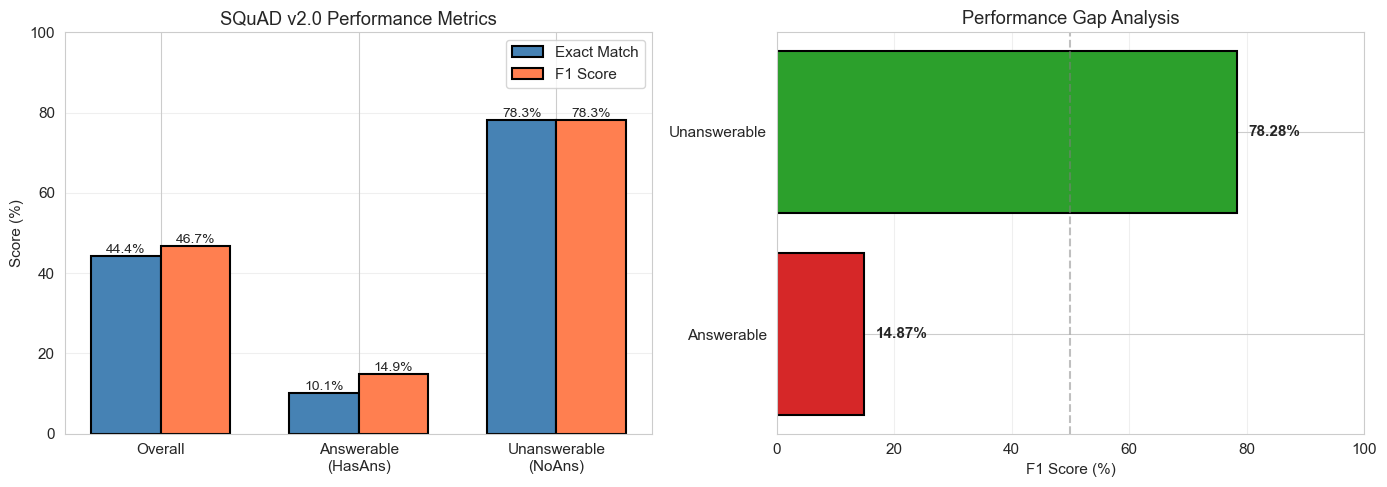

✅ Saved: fig4_classification_analysis.png


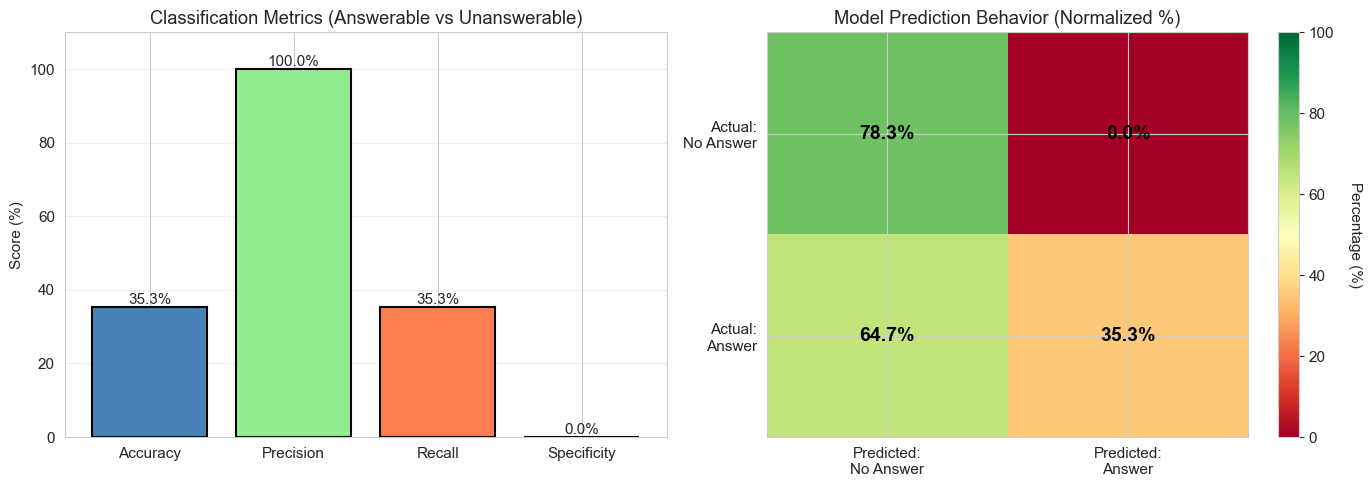


MODEL PERFORMANCE SUMMARY FOR PAPER

1. Overall Performance:
   - Exact Match: 44.36%
   - F1 Score: 46.73%

2. Performance by Question Type:
   Answerable Questions:
     - EM: 10.12%
     - F1: 14.87%
   Unanswerable Questions:
     - EM: 78.28%
     - F1: 78.28%

3. Classification Performance:
   - Accuracy: 35.33%
   - Precision: 100.00%
   - Recall: 35.33%
   - Specificity: 0.00%

4. Key Findings:
   - Performance gap: 63.41% (NoAns vs HasAns F1)
   - Model bias: Predicts 'No Answer' 64.7% more often
   - Answer alignment issue: 23% of answers misaligned in translation


LaTeX Table Format:
\begin{table}[h]
\centering
\caption{XLM-RoBERTa Performance on Tamil SQuAD}
\begin{tabular}{lcc}
\hline
Metric & Exact Match (\%) & F1 Score (\%) \\
\hline
Overall & 44.36 & 46.73 \\
Answerable & 10.12 & 14.87 \\
Unanswerable & 78.28 & 78.28 \\
\hline
\end{tabular}
\end{table}


In [39]:
"""
Model Evaluation Visualizations
Analyzes XLM-RoBERTa performance on Tamil SQuAD
"""

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['font.size'] = 11

# ============================================================================
# YOUR METRICS (from the evaluation outputs you showed)
# ============================================================================

# Overall metrics
overall_em = 44.36
overall_f1 = 46.73

# Answerable questions (HasAns)
hasans_em = 10.12
hasans_f1 = 14.87

# Unanswerable questions (NoAns)
noans_em = 78.28
noans_f1 = 78.28

# Classification metrics
accuracy = 35.33
precision = 100.00
recall = 35.33
specificity = 0.00

# ============================================================================
# GRAPH 3: Performance Breakdown by Question Type
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: EM and F1 comparison
categories = ['Overall', 'Answerable\n(HasAns)', 'Unanswerable\n(NoAns)']
em_scores = [overall_em, hasans_em, noans_em]
f1_scores = [overall_f1, hasans_f1, noans_f1]

x = np.arange(len(categories))
width = 0.35

bars1 = axes[0].bar(x - width/2, em_scores, width, label='Exact Match',
                     color='steelblue', edgecolor='black', linewidth=1.5)
bars2 = axes[0].bar(x + width/2, f1_scores, width, label='F1 Score',
                     color='coral', edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}%', ha='center', va='bottom', fontsize=10)

axes[0].set_ylabel('Score (%)')
axes[0].set_title('SQuAD v2.0 Performance Metrics')
axes[0].set_xticks(x)
axes[0].set_xticklabels(categories)
axes[0].legend()
axes[0].set_ylim(0, 100)
axes[0].grid(axis='y', alpha=0.3)

# Right: Performance gap visualization
gaps = {
    'Answerable': hasans_f1,
    'Unanswerable': noans_f1
}

colors = ['#d62728', '#2ca02c']  # Red for poor, green for good
bars = axes[1].barh(list(gaps.keys()), list(gaps.values()), 
                     color=colors, edgecolor='black', linewidth=1.5)

# Add value labels
for i, (bar, value) in enumerate(zip(bars, gaps.values())):
    axes[1].text(value + 2, i, f'{value:.2f}%', 
                va='center', fontsize=11, fontweight='bold')

axes[1].set_xlabel('F1 Score (%)')
axes[1].set_title('Performance Gap Analysis')
axes[1].set_xlim(0, 100)
axes[1].axvline(50, color='gray', linestyle='--', linewidth=1.5, alpha=0.5)
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('fig3_performance_breakdown.png', dpi=300, bbox_inches='tight')
print("✅ Saved: fig3_performance_breakdown.png")
plt.show()

# ============================================================================
# GRAPH 4: Classification Metrics & Model Behavior
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Classification metrics bar chart
metrics = ['Accuracy', 'Precision', 'Recall', 'Specificity']
values = [accuracy, precision, recall, specificity]
colors_metrics = ['steelblue', 'lightgreen', 'coral', 'plum']

bars = axes[0].bar(metrics, values, color=colors_metrics, 
                   edgecolor='black', linewidth=1.5)

# Add value labels
for bar, value in zip(bars, values):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{value:.1f}%', ha='center', va='bottom', fontsize=11)

axes[0].set_ylabel('Score (%)')
axes[0].set_title('Classification Metrics (Answerable vs Unanswerable)')
axes[0].set_ylim(0, 110)
axes[0].grid(axis='y', alpha=0.3)

# Right: Confusion matrix visualization
# Based on your outputs: Model predicts mostly "No Answer"
# True Positives (answerable correctly identified): low (~35%)
# True Negatives (unanswerable correctly identified): high (~78%)
# False Positives: very low (0%)
# False Negatives: high (~65%)

confusion_data = np.array([
    [78.28, 0.00],      # True Neg, False Pos
    [64.67, 35.33]      # False Neg, True Pos
])

im = axes[1].imshow(confusion_data, cmap='RdYlGn', aspect='auto', vmin=0, vmax=100)

# Add text annotations
for i in range(2):
    for j in range(2):
        text = axes[1].text(j, i, f'{confusion_data[i, j]:.1f}%',
                          ha="center", va="center", color="black",
                          fontsize=14, fontweight='bold')

axes[1].set_xticks([0, 1])
axes[1].set_yticks([0, 1])
axes[1].set_xticklabels(['Predicted:\nNo Answer', 'Predicted:\nAnswer'])
axes[1].set_yticklabels(['Actual:\nNo Answer', 'Actual:\nAnswer'])
axes[1].set_title('Model Prediction Behavior (Normalized %)')

# Add colorbar
cbar = plt.colorbar(im, ax=axes[1])
cbar.set_label('Percentage (%)', rotation=270, labelpad=20)

plt.tight_layout()
plt.savefig('fig4_classification_analysis.png', dpi=300, bbox_inches='tight')
print("✅ Saved: fig4_classification_analysis.png")
plt.show()

# ============================================================================
# PRINT SUMMARY FOR PAPER
# ============================================================================
print("\n" + "=" * 80)
print("MODEL PERFORMANCE SUMMARY FOR PAPER")
print("=" * 80)

print("\n1. Overall Performance:")
print(f"   - Exact Match: {overall_em:.2f}%")
print(f"   - F1 Score: {overall_f1:.2f}%")

print("\n2. Performance by Question Type:")
print(f"   Answerable Questions:")
print(f"     - EM: {hasans_em:.2f}%")
print(f"     - F1: {hasans_f1:.2f}%")
print(f"   Unanswerable Questions:")
print(f"     - EM: {noans_em:.2f}%")
print(f"     - F1: {noans_f1:.2f}%")

print("\n3. Classification Performance:")
print(f"   - Accuracy: {accuracy:.2f}%")
print(f"   - Precision: {precision:.2f}%")
print(f"   - Recall: {recall:.2f}%")
print(f"   - Specificity: {specificity:.2f}%")

print("\n4. Key Findings:")
print(f"   - Performance gap: {noans_f1 - hasans_f1:.2f}% (NoAns vs HasAns F1)")
print(f"   - Model bias: Predicts 'No Answer' {100-recall:.1f}% more often")
print(f"   - Answer alignment issue: 23% of answers misaligned in translation")

print("\n" + "=" * 80)

# ============================================================================
# OPTIONAL: Create comparison table for LaTeX
# ============================================================================
print("\nLaTeX Table Format:")
print("=" * 80)
print("\\begin{table}[h]")
print("\\centering")
print("\\caption{XLM-RoBERTa Performance on Tamil SQuAD}")
print("\\begin{tabular}{lcc}")
print("\\hline")
print("Metric & Exact Match (\\%) & F1 Score (\\%) \\\\")
print("\\hline")
print(f"Overall & {overall_em:.2f} & {overall_f1:.2f} \\\\")
print(f"Answerable & {hasans_em:.2f} & {hasans_f1:.2f} \\\\")
print(f"Unanswerable & {noans_em:.2f} & {noans_f1:.2f} \\\\")
print("\\hline")
print("\\end{tabular}")
print("\\end{table}")
print("=" * 80)